# Task Description

* Background information: the exercise focuses on surgical tool segmentation, which is crucial in various computer-assisted intervention applications. This task involves processing RGB video frames and assigning semantic labels at the pixel level.

* Goal: your objective is to solve the semantic segmentation task and generate masks of prominent objects, including surgical tool parts, as well as thin and small tools such as surgical clips, suturing threads, and needles.

* Data, you can access the training and test sets using the following links (for more information see https://www.synapse.org/#!Synapse:syn27618412/wiki/616881)



# Dataset:

Train set: https://rdr.ucl.ac.uk/articles/dataset/SAR-RARP50_train_set/24932529 

Test set: https://rdr.ucl.ac.uk/articles/dataset/SAR-RARP50_test_set/24932499

# Environment Preparation

## create a virtual environment using conda and activate it.
conda create --name openmmlab python=3.8 -y
conda activate openmmlab
## install pytorch
pip install torch==1.12.0+cu116 torchvision==0.13.0+cu116 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu116
## install mmcv
pip install -U openmim
mim install mmengine
pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.12.0/index.html

In [1]:
# 检查平台上 PyTorch 版本
!pip list | grep torch

torch                  1.12.0+cu116
torchaudio             0.12.0+cu116
torchvision            0.13.0+cu116


In [8]:
# 安装 PyTorch 对应版本的 mmcv-full
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html


/data1/anaconda/envs/openmmlab2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data1/anaconda/envs/openmmlab2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


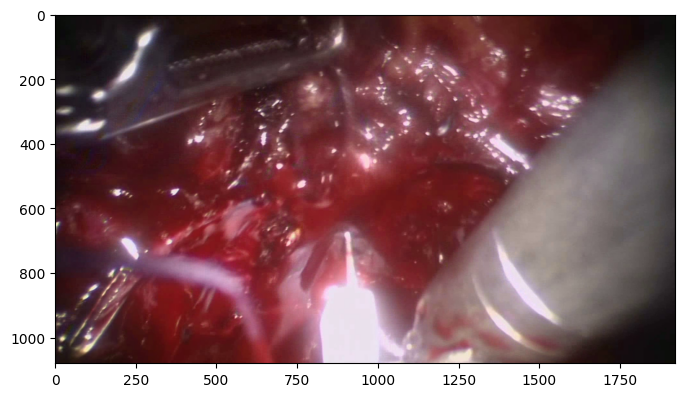

In [1]:
# visualise an image in the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('data/images/video_05_000003900.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

我们需要将标注转换成图像中的分割图

In [2]:
import os.path as osp
import numpy as np
from PIL import Image

# set the data root and the directory names of images and labels
data_root = 'data'
img_dir = 'images'
ann_dir = 'labels'

# define the names and colors of all classes
classes = ('Background', 'Tool clasper', 'Tool wrist', 'Tool shaft', 'Suturing needle', 'Thread', 'Suction tool', 'Needle Holder', 'Clamps', 'Catheter')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51], [120, 240, 90], [244, 20, 57]]


(1080, 1920)


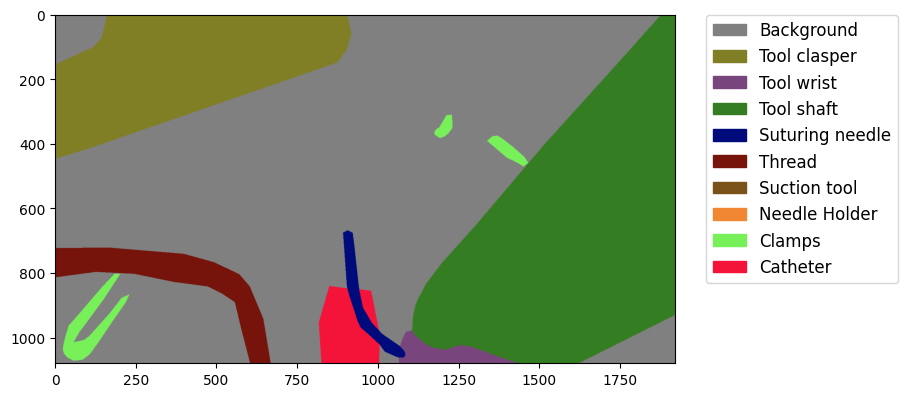

In [3]:
# 可视化分割图
import matplotlib.patches as mpatches
img = Image.open('data/labels/video_05_000003900.png').convert('L')
print(np.array(img).shape)
plt.figure(figsize=(8, 6))
img.putpalette(np.array(palette, dtype=np.uint8))
img.save("temp.png")
img = Image.open("temp.png")
im = plt.imshow(np.array(img.convert('RGB')))

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(10)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='large')

plt.show()

Define a new class for our dataset SAR-RARP50 (The classes and palette should be set here).

In [4]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class SARRARP50(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Creating the config file

In [21]:
from mmcv import Config
cfg = Config.fromfile('configs/upernet/upernet_r50_512x512_40k_voc12aug.py')

The above config file is an Upernet model with a Resnet backbone pretrained on the dataset VOC. Now we need to make some adaptions for our dataset SAR-RARP50. 

In [22]:
from mmseg.apis import set_random_seed

cfg.device = 'cuda'

# Because I used 1 gpu to train the model, the argument type is 'BN'. If you have multiple gpus, you can input 'SyncBN'
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# Set the number of output classes
cfg.model.decode_head.num_classes = 10
cfg.model.auxiliary_head.num_classes = 10

# Set data_type and data_root
cfg.dataset_type = 'SARRARP50'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
# cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1920, 1080), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1920, 1080),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/test.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/test.txt'

# load the pretrained weights of Upernet
cfg.load_from = './work_dirs/latest.pth'

# set the saved directory path of checkpoints and logs
cfg.work_dir = './test'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 2000
cfg.checkpoint_config.interval = 2000

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1,2)

# print(f'Config:\n{cfg.pretty_text}')
cfg.dump('config.py')

## Training the model

In [17]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建模型
model = build_segmentor(cfg.model)

# 将类别名增加到模型中，便于进行可视化
model.CLASSES = datasets[0].CLASSES

# 创建 work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2024-02-20 00:42:55,478 - mmseg - INFO - Loaded 10128 images


2024-02-20 00:42:56,040 - mmseg - INFO - Loaded 3252 images
2024-02-20 00:42:56,042 - mmseg - INFO - load checkpoint from local path: ./work_dirs/latest.pth
2024-02-20 00:42:56,291 - mmseg - INFO - Start running, host: xudong@avatar, work_dir: /data2/xudong/wangchao/SAR-RARP50/mmsegmentation-0.x/test
2024-02-20 00:42:56,293 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LO

## Inference

In [18]:
from mmseg.apis import inference_segmentor
from mmseg.apis import show_result_pyplot

img = mmcv.imread('data/images/video_06_000018240.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

# set a color for each patch
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(10)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])